# Загрузка библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms

# Данные

In [3]:
train = pd.read_csv('/content/drive/MyDrive/MFTI/SEM_02/Deep_learning/fmnist_train.csv')
test = pd.read_csv('/content/drive/MyDrive/MFTI/SEM_02/Deep_learning/fmnist_test.csv')
subm = pd.read_csv('/content/drive/MyDrive/MFTI/SEM_02/Deep_learning/sample_submission.csv')

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [5]:
print(train.info())
print(test.info())
print(subm.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17040 entries, 0 to 17039
Columns: 786 entries, label to Id
dtypes: float64(424), int64(362)
memory usage: 102.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, pixel1 to Id
dtypes: int64(785)
memory usage: 59.9 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Id      10000 non-null  int64
 1   label   10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB
None


In [6]:
X = train.drop(columns =['label', 'Id'])
y = train['label'].values

In [7]:
pixel_columns = [col for col in train.columns if col.startswith('pixel')]
X = train[pixel_columns].values.astype(np.uint8)
y = train['label'].values

X = X.reshape(-1, 28, 28)

### Визуализация примера из данных

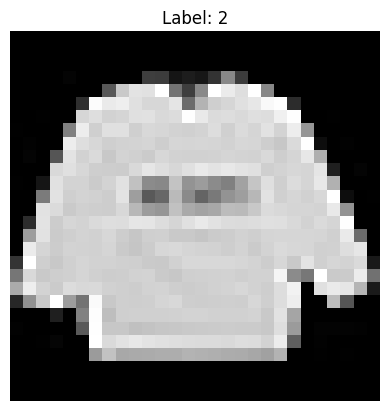

In [8]:
plt.imshow(X[0], cmap='gray')
plt.title(f"Label: {y[0]}")
plt.axis('off')
plt.show()

### Разделение данных на тренировочные и валидационные

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(13632, 28, 28)
(3408, 28, 28)
(13632,)
(3408,)


### Обработка для дальнейшего использования в обучении модели

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [12]:
def preprocess_images(X):
    X_tensor = torch.stack([transform(Image.fromarray(img)) for img in X])
    return X_tensor

def create_dataloader(X, y, batch_size=64, shuffle=True):
    X_tensor = preprocess_images(X)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [13]:
train_loader = create_dataloader(X_train, y_train)
val_loader = create_dataloader(X_val, y_val, shuffle=False)

# Модель

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)   # (28-3+1)=26
        self.pool = nn.MaxPool2d(2, 2)                 # 13x13
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # (13-3+1)=11 → pool → 5x5
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # → (N, 32, 13, 13)
        x = self.pool(F.relu(self.conv2(x)))   # → (N, 64, 5, 5)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Параметры

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15

### Обучение

In [16]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Accuracy = {train_acc:.4f}")

Epoch 1: Loss = 148.4032, Train Accuracy = 0.7432
Epoch 2: Loss = 93.7340, Train Accuracy = 0.8388
Epoch 3: Loss = 81.7807, Train Accuracy = 0.8583
Epoch 4: Loss = 72.8207, Train Accuracy = 0.8711
Epoch 5: Loss = 66.6559, Train Accuracy = 0.8838
Epoch 6: Loss = 60.3202, Train Accuracy = 0.8937
Epoch 7: Loss = 56.1763, Train Accuracy = 0.9003
Epoch 8: Loss = 50.8877, Train Accuracy = 0.9112
Epoch 9: Loss = 45.7678, Train Accuracy = 0.9187
Epoch 10: Loss = 41.6410, Train Accuracy = 0.9272
Epoch 11: Loss = 38.5785, Train Accuracy = 0.9324
Epoch 12: Loss = 33.7452, Train Accuracy = 0.9404
Epoch 13: Loss = 30.8000, Train Accuracy = 0.9473
Epoch 14: Loss = 27.3265, Train Accuracy = 0.9536
Epoch 15: Loss = 25.5291, Train Accuracy = 0.9567


### Валидация на тесте

In [17]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = correct / total
print(f"Validation Accuracy = {val_acc:.4f}")

Validation Accuracy = 0.8876


### Вывод:
финальная метрика `Accuracy` на тестовых данных показала `score>=0.80`, что соответствует требованию по качеству модели

# Предсказание для `Submissions`

In [18]:
test_ids = test['Id'].values
X_test = test.drop(columns=['Id']).values.astype(np.uint8)
X_test = X_test.reshape(-1, 28, 28)

X_test_tensor = preprocess_images(X_test)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
all_preds = []

with torch.no_grad():
    for images_tuple in test_loader:
        images = images_tuple[0].to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

submission = pd.DataFrame({
    'Id': test_ids,
    'label': all_preds
})

submission.to_csv('/content/drive/MyDrive/MFTI/SEM_02/Deep_learning/submission_op.csv', index=False)

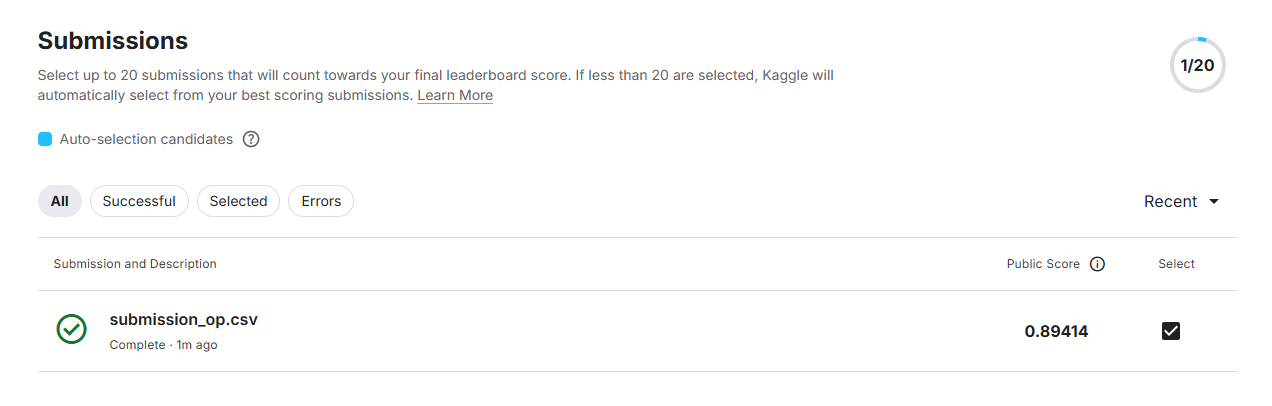

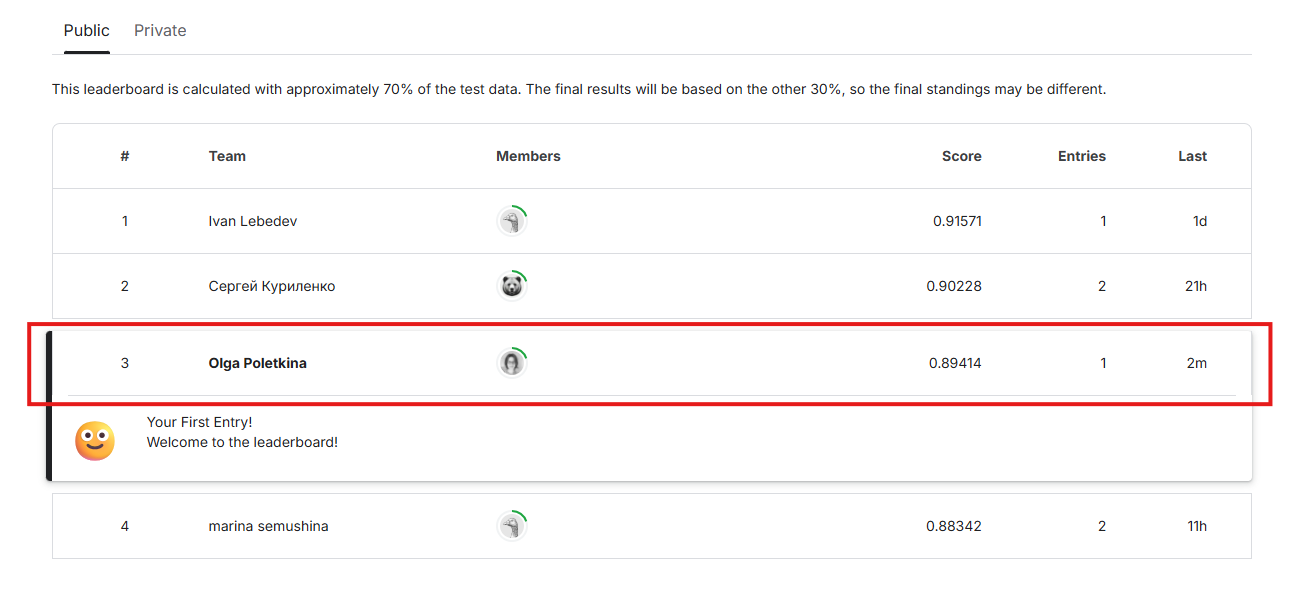